In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, recall_score, auc, roc_auc_score, roc_curve, precision_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall, plot_roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# Define correct local paths
data_dir = r"C:\multi-repo-analyzer\ml_engine\data"
# Using os.path.join for cross-platform compatibility, though standard forward slashes often work
folders = [
    os.path.join("JavascriptSamplesObfuscated", "JavascriptSamplesObfuscated"), 
    os.path.join("JavascriptSamplesNotObfuscated", "JavascriptSamples")
]

data = []
labels = []

print("Loading data...")
for folder in folders:
    full_path = os.path.join(data_dir, folder)
    print(f"Scanning {full_path}...")
    if not os.path.exists(full_path):
        print(f"Warning: Path not found: {full_path}")
        continue
        
    files = os.listdir(full_path)
    for file in files:
        file_path = os.path.join(full_path, file)
        try:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                js = f.read().replace("\n", "")
                js = str(js)
                data.append(js)
                # Use a simplified label based on the folder name
                if "NotObfuscated" in folder:
                    labels.append("not-obfuscated")
                else:
                    labels.append("obfuscated")
        except Exception as e:
            pass # Skip files that can't be read

df = pd.DataFrame({"js": data, "label": labels})
print(f"Loaded {len(df)} samples.")
df.head()

Loading data...
Scanning C:\multi-repo-analyzer\ml_engine\data\JavascriptSamplesObfuscated\JavascriptSamplesObfuscated...
Scanning C:\multi-repo-analyzer\ml_engine\data\JavascriptSamplesNotObfuscated\JavascriptSamples...
Loaded 3375 samples.


,js,label
0,var _0x440a=['________________________________...,obfuscated
1,"var _0x1c6d=['bind','prototype','validate$','v...",obfuscated
2,"var _0x3b0d=['dataSources','setMaxListeners','...",obfuscated
3,"var _0x9ed0=['prop','href','[object\x20SVGAnim...",obfuscated
4,"export default()=>[{'id':0x1,'name':'1'},{'id'...",obfuscated


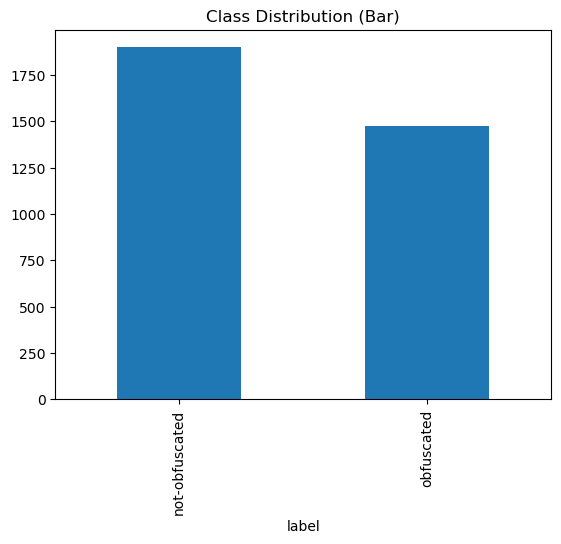

In [4]:
df["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution (Bar)")
plt.show()

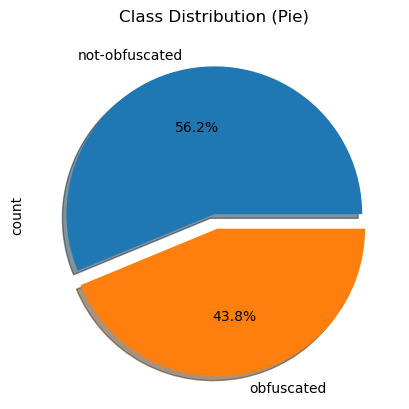

In [5]:
df["label"].value_counts().plot(kind="pie", autopct="%.1f%%", shadow=True, explode=[0, 0.1])
plt.title("Class Distribution (Pie)")
plt.show()

In [6]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

df["label"] = label_encoder(df["label"])
class_names = ["not-obfuscated", "obfuscated"]

X = df["js"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hv = HashingVectorizer(ngram_range=(1, 3))
X_train = hv.fit_transform(X_train)
X_test = hv.transform(X_test)

tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

label ['not-obfuscated' 'obfuscated']
X_train: (2700, 1048576)
X_test: (675, 1048576)
y_train: (2700,)
y_test: (675,)


Logistic Regression Train Time: 6.463021278381348
Logistic Regression Train Score: 0.9811111111111112
Logistic Regression Test Score: 0.9614814814814815
Logistic Regression Precision Score: 0.9409937888198758
Logistic Regression F1 Score: 0.9588607594936709
Logistic Regression Recall Score: 0.9774193548387097
Logistic Regression Accuracy Score: 0.9614814814814815
                precision    recall  f1-score   support

not-obfuscated       0.98      0.95      0.96       365
    obfuscated       0.94      0.98      0.96       310

      accuracy                           0.96       675
     macro avg       0.96      0.96      0.96       675
  weighted avg       0.96      0.96      0.96       675



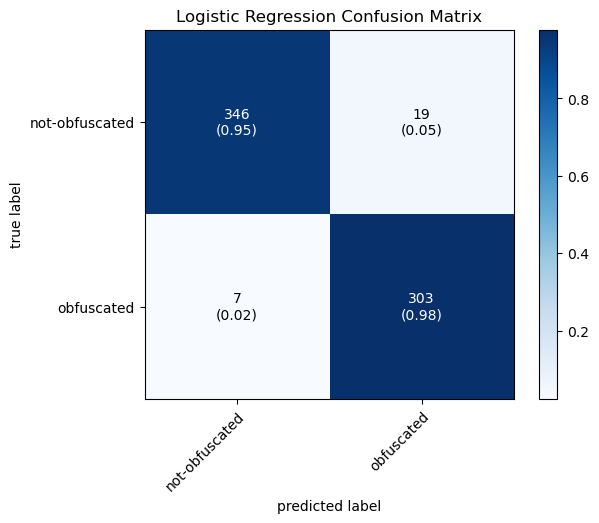

In [7]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
start = time.time()
logreg.fit(X_train, y_train)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)

logreg_pred_train = logreg.predict(X_train)
logreg_pred_test = logreg.predict(X_test)

logreg_train_score = accuracy_score(logreg_pred_train, y_train)
logreg_test_score = accuracy_score(logreg_pred_test, y_test)
print("Logistic Regression Train Score:", logreg_train_score)
print("Logistic Regression Test Score:", logreg_test_score)

logreg_precision_score = precision_score(y_test, logreg_pred_test)
logreg_f1_score = f1_score(y_test, logreg_pred_test)
logreg_recall_score = recall_score(y_test, logreg_pred_test)
logreg_accuracy_score = accuracy_score(y_test, logreg_pred_test)

print("Logistic Regression Precision Score:", logreg_precision_score)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("Logistic Regression Recall Score:", logreg_recall_score)
print("Logistic Regression Accuracy Score:", logreg_accuracy_score)
print(classification_report(y_test, logreg_pred_test, target_names=class_names))

logreg_cm = confusion_matrix(y_test, logreg_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=logreg_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=class_names)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

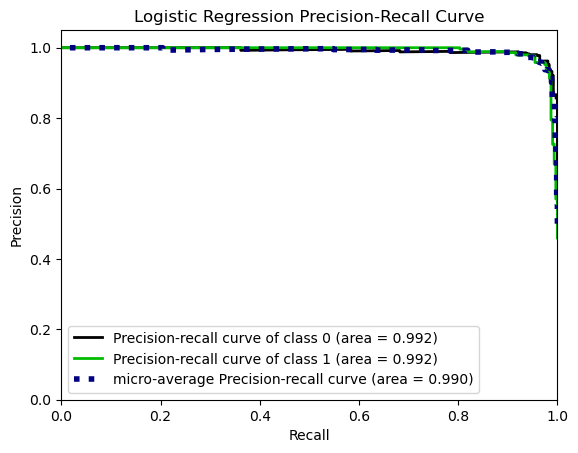

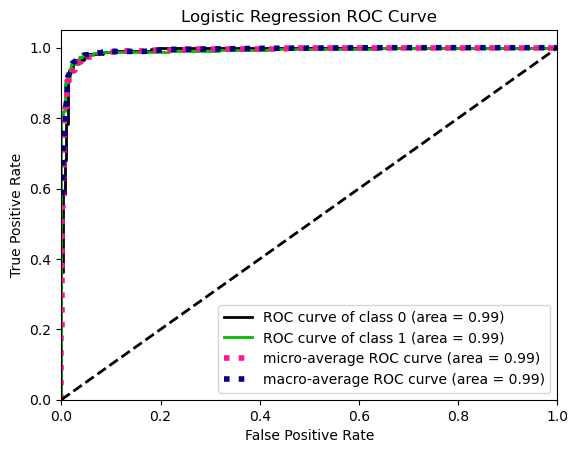

In [8]:
logreg_test_proba = logreg.predict_proba(X_test)
plot_precision_recall(y_test, logreg_test_proba)
plt.title("Logistic Regression Precision-Recall Curve")
plt.show()
plot_roc_curve(y_test, logreg_test_proba)
plt.title("Logistic Regression ROC Curve")
plt.show()

Random Forest Train Time: 50.84123110771179
Random Forest Train Score: 1.0
Random Forest Test Score: 0.9718518518518519
Random Forest Precision Score: 0.9619047619047619
Random Forest F1 Score: 0.9696
Random Forest Recall Score: 0.9774193548387097
Random Forest Accuracy Score: 0.9718518518518519
                precision    recall  f1-score   support

not-obfuscated       0.98      0.97      0.97       365
    obfuscated       0.96      0.98      0.97       310

      accuracy                           0.97       675
     macro avg       0.97      0.97      0.97       675
  weighted avg       0.97      0.97      0.97       675



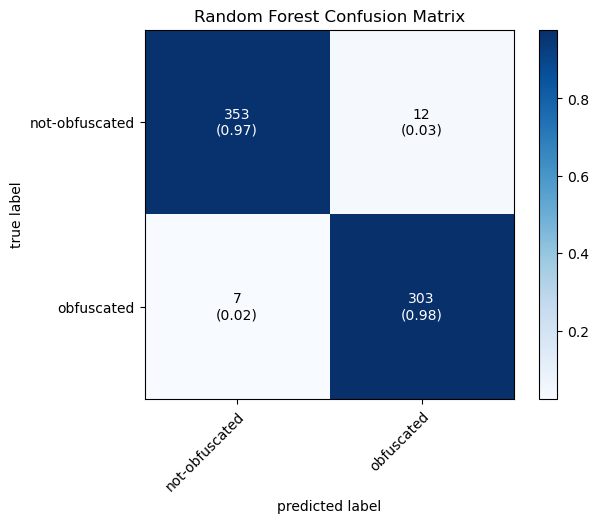

In [9]:
# Random Forest
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
rf_time = end - start
print("Random Forest Train Time:", rf_time)
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

rf_train_score = accuracy_score(rf_pred_train, y_train)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)

rf_precision_score = precision_score(y_test, rf_pred_test)
rf_f1_score = f1_score(y_test, rf_pred_test)
rf_recall_score = recall_score(y_test, rf_pred_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)
print(classification_report(y_test, rf_pred_test, target_names=class_names))

rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=class_names)
plt.title("Random Forest Confusion Matrix")
plt.show()

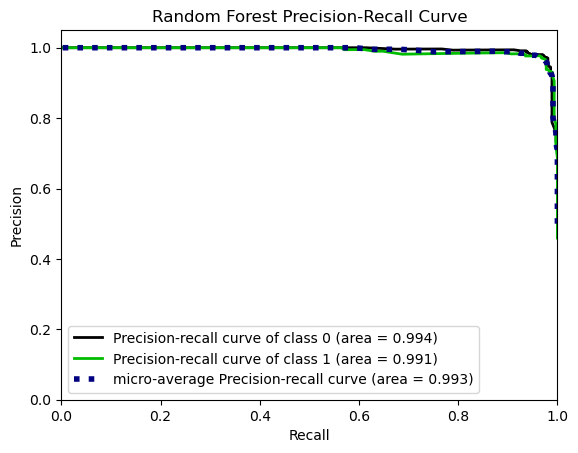

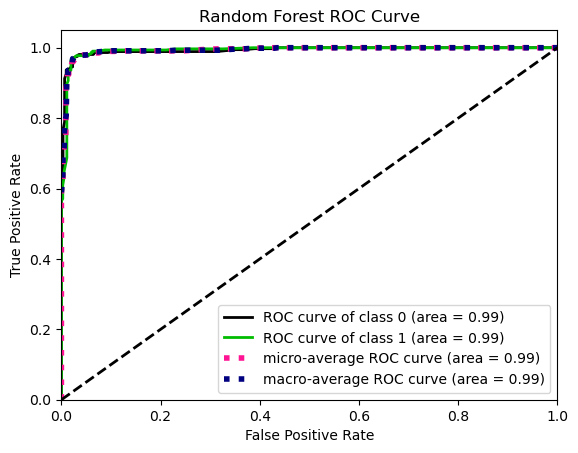

In [10]:
rf_test_proba = rf.predict_proba(X_test)
plot_precision_recall(y_test, rf_test_proba)
plt.title("Random Forest Precision-Recall Curve")
plt.show()
plot_roc_curve(y_test, rf_test_proba)
plt.title("Random Forest ROC Curve")
plt.show()

Decision Tree Train Time: 12.718009948730469
Decision Tree Train Score: 1.0
Decision Tree Test Score: 0.9762962962962963
Decision Tree Precision Score: 0.9651898734177216
Decision Tree F1 Score: 0.9744408945686901
Decision Tree Recall Score: 0.9838709677419355
Decision Tree Accuracy Score: 0.9762962962962963
                precision    recall  f1-score   support

not-obfuscated       0.99      0.97      0.98       365
    obfuscated       0.97      0.98      0.97       310

      accuracy                           0.98       675
     macro avg       0.98      0.98      0.98       675
  weighted avg       0.98      0.98      0.98       675



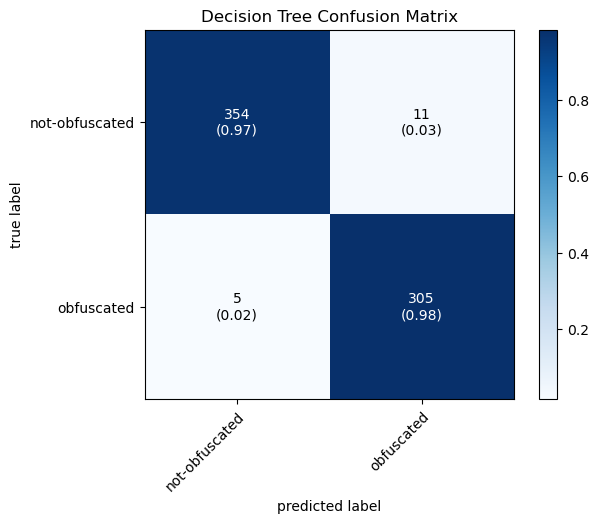

In [11]:
# Decision Tree
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
dt_time = end - start
print("Decision Tree Train Time:", dt_time)
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

dt_train_score = accuracy_score(dt_pred_train, y_train)
dt_test_score = accuracy_score(dt_pred_test, y_test)
print("Decision Tree Train Score:", dt_train_score)
print("Decision Tree Test Score:", dt_test_score)

dt_precision_score = precision_score(y_test, dt_pred_test)
dt_f1_score = f1_score(y_test, dt_pred_test)
dt_recall_score = recall_score(y_test, dt_pred_test)
dt_accuracy_score = accuracy_score(y_test, dt_pred_test)

print("Decision Tree Precision Score:", dt_precision_score)
print("Decision Tree F1 Score:", dt_f1_score)
print("Decision Tree Recall Score:", dt_recall_score)
print("Decision Tree Accuracy Score:", dt_accuracy_score)
print(classification_report(y_test, dt_pred_test, target_names=class_names))

dt_cm = confusion_matrix(y_test, dt_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=dt_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=class_names)
plt.title("Decision Tree Confusion Matrix")
plt.show()

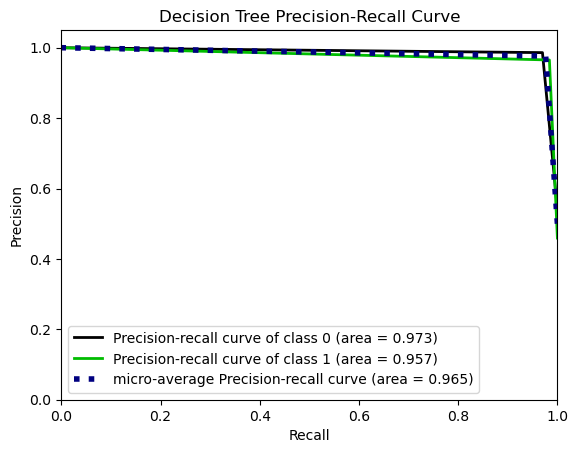

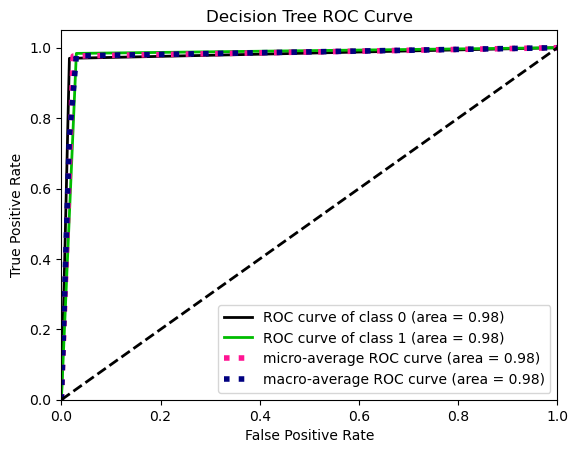

In [12]:
dt_test_proba = dt.predict_proba(X_test)
plot_precision_recall(y_test, dt_test_proba)
plt.title("Decision Tree Precision-Recall Curve")
plt.show()
plot_roc_curve(y_test, dt_test_proba)
plt.title("Decision Tree ROC Curve")
plt.show()

XGBClassifier Train Time: 228.1518108844757
XGBClassifier Train Score: 0.9992592592592593
XGBClassifier Test Score: 0.9822222222222222
XGBClassifier Precision Score: 0.9775641025641025
XGBClassifier F1 Score: 0.9807073954983923
XGBClassifier Recall Score: 0.9838709677419355
XGBClassifier Accuracy Score: 0.9822222222222222
                precision    recall  f1-score   support

not-obfuscated       0.99      0.98      0.98       365
    obfuscated       0.98      0.98      0.98       310

      accuracy                           0.98       675
     macro avg       0.98      0.98      0.98       675
  weighted avg       0.98      0.98      0.98       675



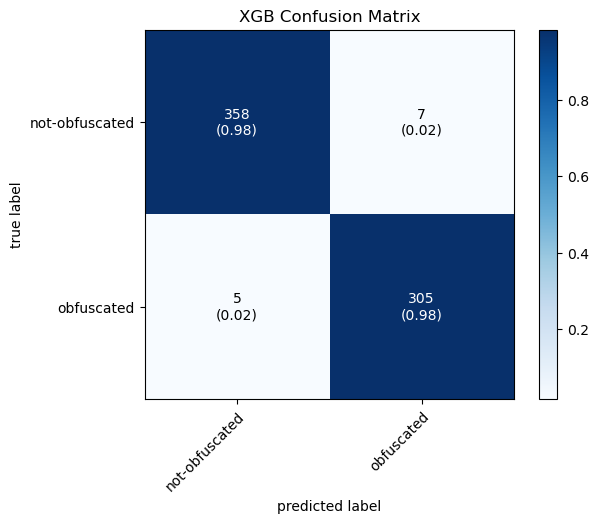

In [13]:
# XGBClassifier
xgb = XGBClassifier(eval_metric='logloss') 
start = time.time()
xgb.fit(X_train, y_train)
end = time.time()
xgb_time = end - start
print("XGBClassifier Train Time:", xgb_time)
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)

xgb_train_score = accuracy_score(xgb_pred_train, y_train)
xgb_test_score = accuracy_score(xgb_pred_test, y_test)
print("XGBClassifier Train Score:", xgb_train_score)
print("XGBClassifier Test Score:", xgb_test_score)

xgb_precision_score = precision_score(y_test, xgb_pred_test)
xgb_f1_score = f1_score(y_test, xgb_pred_test)
xgb_recall_score = recall_score(y_test, xgb_pred_test)
xgb_accuracy_score = accuracy_score(y_test, xgb_pred_test)

print("XGBClassifier Precision Score:", xgb_precision_score)
print("XGBClassifier F1 Score:", xgb_f1_score)
print("XGBClassifier Recall Score:", xgb_recall_score)
print("XGBClassifier Accuracy Score:", xgb_accuracy_score)
print(classification_report(y_test, xgb_pred_test, target_names=class_names))

xgb_cm = confusion_matrix(y_test, xgb_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=xgb_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=class_names)
plt.title("XGB Confusion Matrix")
plt.show()

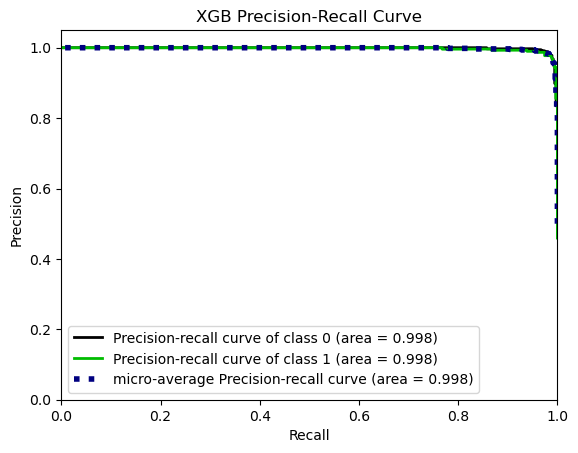

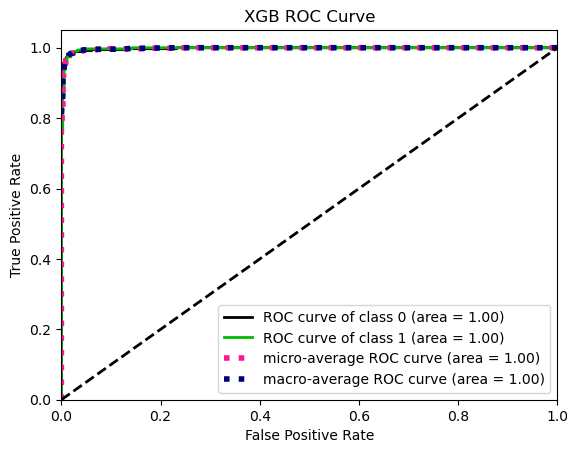

In [14]:
xgb_test_proba = xgb.predict_proba(X_test)
plot_precision_recall(y_test, xgb_test_proba)
plt.title("XGB Precision-Recall Curve")
plt.show()
plot_roc_curve(y_test, xgb_test_proba)
plt.title("XGB ROC Curve")
plt.show()

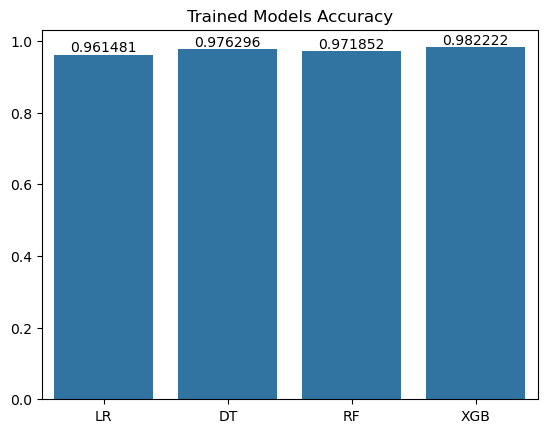

In [15]:
labels = ["LR", "DT", "RF", "XGB"]
scores = [logreg_test_score, dt_test_score, rf_test_score, xgb_test_score]
def plot_model_plot(labels, scores):
    plt.figure()
    ax = sns.barplot(x=labels, y=scores)
    ax.set_title("Trained Models Accuracy")
    for container in ax.containers:
        ax.bar_label(container)
plot_model_plot(labels, scores)
plt.show()

In [16]:
import joblib

# Save the best model (e.g., XGBoost)
joblib.dump(xgb, 'obfuscation_xgb_model.joblib')
print("Model saved successfully!")

Model saved successfully!
